# 7.2 Сложные модели прогнозирования

In [1]:
import pandas as pd

import pandas_datareader.data as web # extract data from various Internet sources into a pandas DataFrame

import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

## Полезные графики рядов

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = pd.rolling_mean(y, window=12)
    rolstd = pd.rolling_std(y, window=12)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [4]:
#######################
# разложение на компоненты
#########################
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(Y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [5]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
# Выбор модели ARIMA согласно AIC
def arima_best_order(timeseries):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(2)  # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

In [7]:
# зафиксируем выборку
np.random.seed(1)

In [8]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(1000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


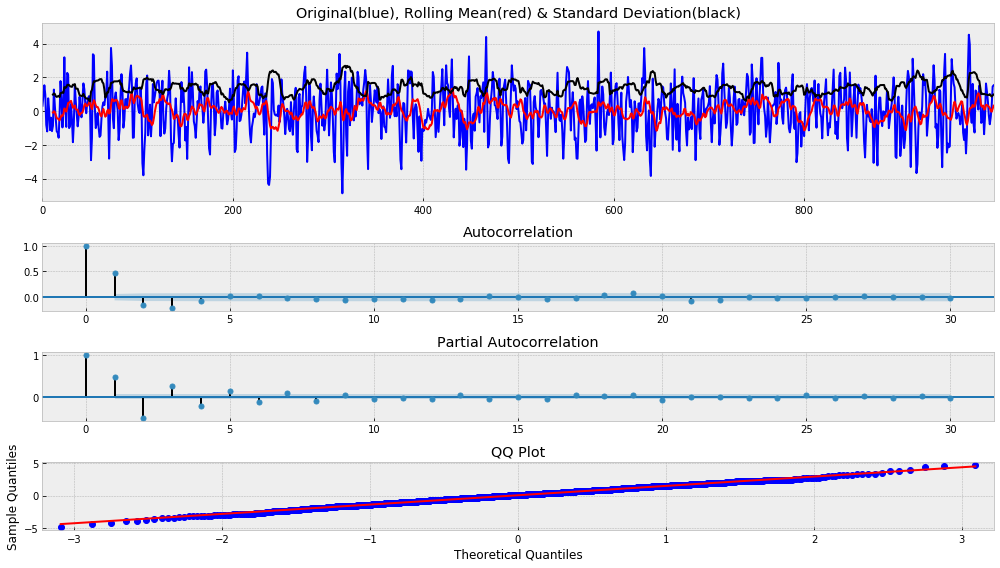

In [9]:
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

In [10]:
# statmodels очень любит даты. не будем ему мешать))
# зададим помесячный индекс длинною 1000 дат с 1935 года

#  Укажем формат времени
start = datetime.datetime.strptime("1935-01-01", "%Y-%m-%d")
# создадим лист из дат
date_list = [start + relativedelta(months=x) for x in range(0,1000)]
# конвертируем ndarray в dataframe
arma22_df = pd.DataFrame(arma22, columns=['arma22'], index=date_list)

In [18]:
# Оценим модель с писходным порядком
mdl = smt.ARMA(arma22_df, order=(2, 2)).fit( maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary().tables[0])
p(mdl.summary().tables[1])

                              ARMA Model Results                              
Dep. Variable:                 arma22   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1417.526
Method:                           mle   S.D. of innovations              0.998
Date:                Fri, 02 Feb 2018   AIC                           2845.051
Time:                        18:45:08   BIC                           2869.590
Sample:                    01-01-1935   HQIC                          2854.377
                         - 04-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.arma22     0.5501      0.131      4.214      0.000       0.294       0.806
ar.L2.arma22    -0.2598      0.035     -7.486      0.000      -0.328      -0.192
ma.L1.arma22     0.4420      0.134      3.29

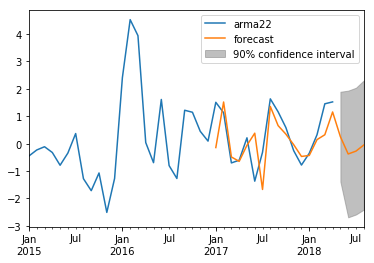

In [19]:
# Нарисуем прогноз
fig, ax = plt.subplots()
ax = arma22_df.ix['2015-01':].plot(ax=ax)
fig = mdl.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)

In [20]:
# Оценим модель выбрав порядок с минимальным AIC

mdl_aic = arima_best_order(arma22_df)
p(mdl_aic.summary().tables[0])
p(mdl_aic.summary().tables[1])

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

aic: 2844.35183 | order: (4, 0, 3)
                              ARMA Model Results                              
Dep. Variable:                 arma22   No. Observations:                 1000
Model:                     ARMA(4, 3)   Log Likelihood               -1414.176
Method:                           mle   S.D. of innovations              0.994
Date:                Fri, 02 Feb 2018   AIC                           2844.352
Time:                        18:45:36   BIC                           2883.614
Sample:                    01-01-1935   HQIC                          2859.274
                         - 04-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.arma22     0.2903      0.150      1.941      0.053      -0.003       0.584
ar.L2.arma22     0.4958      0.131      3.776      0.000       0.238       0.753
ar.L3.arm

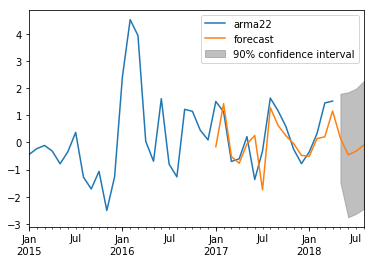

In [21]:
fig, ax = plt.subplots()
ax = arma22_df.ix['2015-01':].plot(ax=ax)
fig = mdl_aic.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)#Нарисуем оба прогноза
fig, ax = plt.subplots()
ax = arma22_df.ix['2015-01':].plot(ax=ax)
fig = mdl.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)
fig = mdl_aic.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)

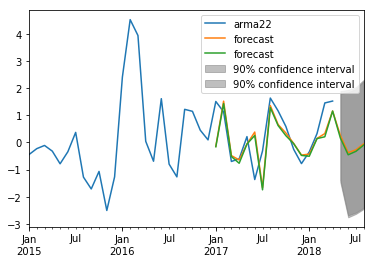

In [22]:
#Нарисуем оба прогноза
fig, ax = plt.subplots()
ax = arma22_df.ix['2015-01':].plot(ax=ax)
fig = mdl.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)
fig = mdl_aic.plot_predict('2017-01', '2018-08', dynamic=False, ax=ax, plot_insample=False, alpha=0.1)

## Работа с реальными рядами

In [23]:
# Загрузим данные
df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

In [24]:
#  Укажем формат времени
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


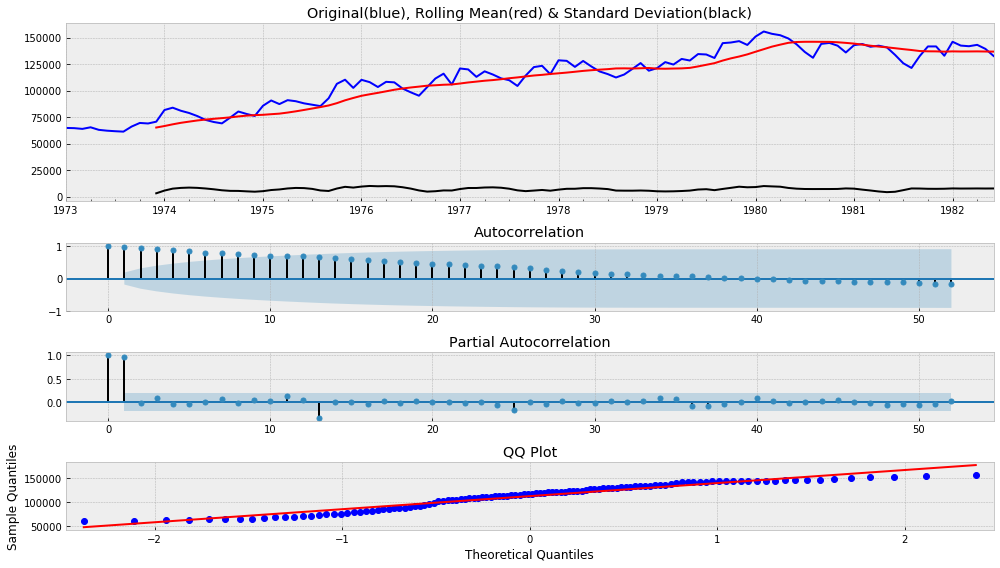

In [25]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)




tsplot(df.riders, lags=52)

In [26]:
#df.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
#plt.savefig('month_ridership.png', bbox_inches='tight')

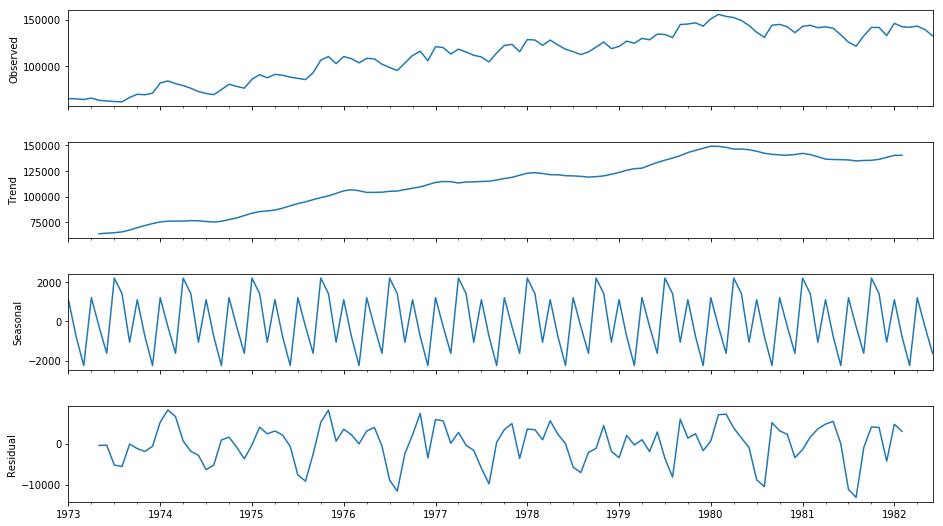

In [27]:
decomposition = seasonal_decompose(df.riders, freq=9)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [28]:
test_stationarity(df.riders)

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


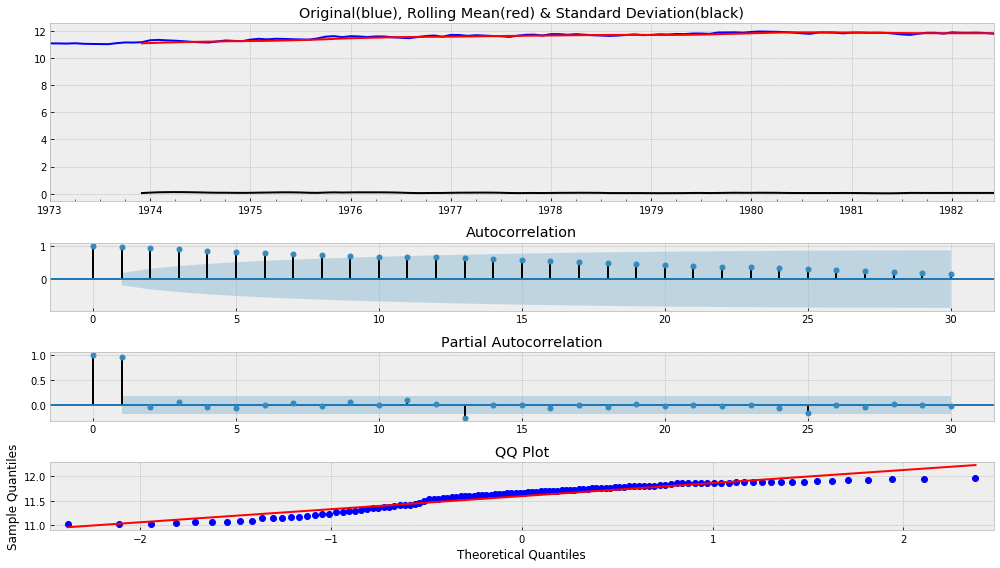

In [29]:
df.riders_log = df.riders.apply(lambda x: np.log(x))
tsplot(df.riders_log, lags=30)

In [30]:
test_stationarity(df.riders_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.677830
p-value                          0.442570
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [31]:
df['first_difference'] = df.riders - df.riders.shift(1)
test_stationarity(df.first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [32]:
df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)
test_stationarity(df.log_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -2.047539
p-value                          0.266126
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [33]:
df['seasonal_difference'] = df.riders - df.riders.shift(12)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [34]:
df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [35]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


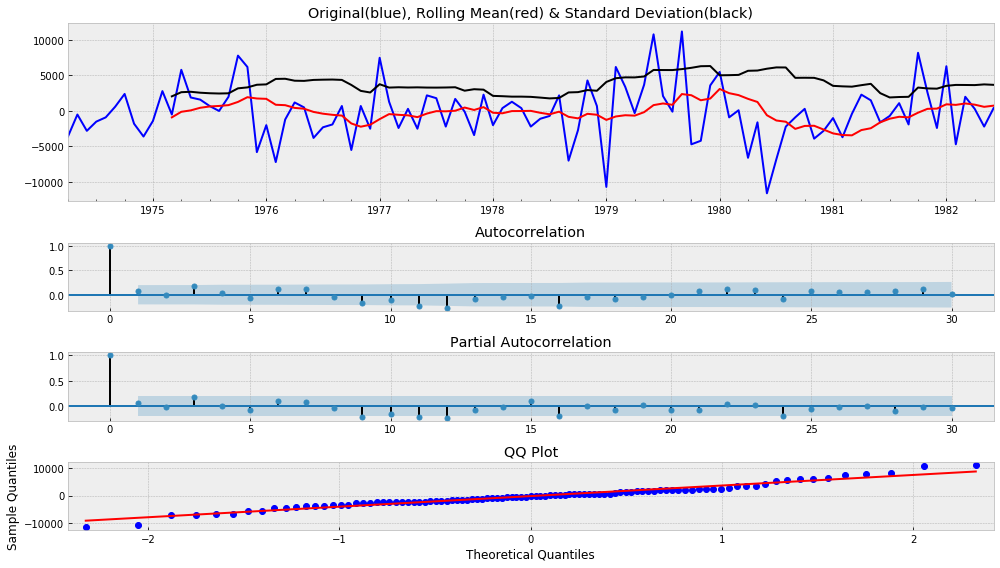

In [36]:
tsplot(df.seasonal_first_difference.iloc[15:], lags=30)

In [37]:
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -8.882112e+00
p-value                        1.309452e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


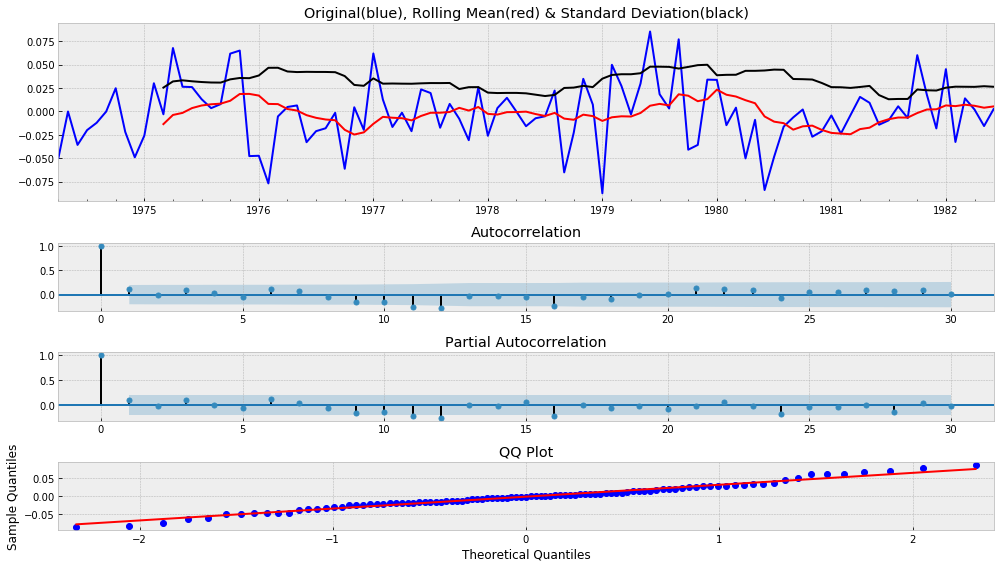

In [38]:
tsplot(df.log_seasonal_first_difference.iloc[15:], lags=30)

### Дополнительная информация о трансформации данных здесь
http://people.duke.edu/~rnau/whatuse.htm


In [39]:
# Подбор модели
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(2,1,1,12))
results = mod.fit()
p(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -970.339
Date:                            Fri, 02 Feb 2018   AIC                           1948.678
Time:                                    18:48:38   BIC                           1959.622
Sample:                                01-01-1973   HQIC                          1953.120
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5058      0.157      3.214      0.001       0.197       0.814
ar.S.L24      -0.0647      0.130   

In [40]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
p(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Fri, 02 Feb 2018   AIC                           1946.514
Time:                                    18:48:44   BIC                           1954.723
Sample:                                01-01-1973   HQIC                          1949.845
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.9982      0.117   

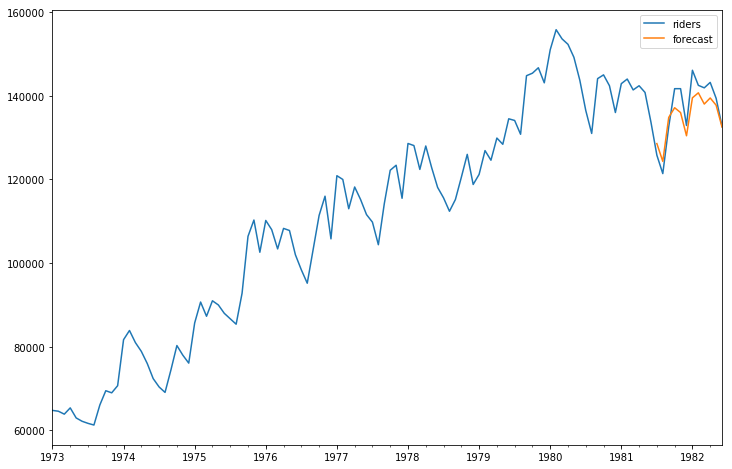

In [41]:
# Построение прогноза
df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)
df[['riders', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


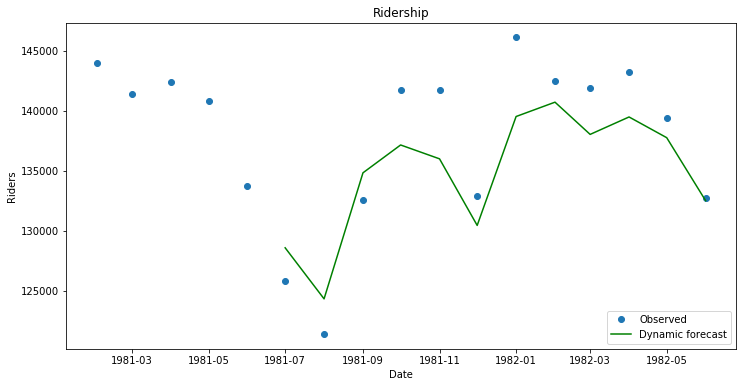

In [42]:
# Сравнение прогноза с даннымми
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
plt.savefig('ts_predict_compare.png', bbox_inches='tight')

# ARCH
Fit ARIMA(p, d, q) model to SPY Returns

pick best order and final model based on aic

In [43]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']

# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1167598800&period2=1420145999&interval=1d&events=history&crumb=9%5Cu002Fz6wnx4dqB

In [44]:
best_mdl = arima_best_order(lrets.SPY)

# нарисуем остатки ARIMA
_ = tsplot(best_mdl.resid, lags=30)

NameError: name 'lrets' is not defined

In [45]:
# Спрогнозируем на 21 день  доходность SPY с 95%, 99% ДИ
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI


NameError: name 'best_mdl' is not defined

In [46]:
idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

NameError: name 'data' is not defined

NameError: name 'lrets' is not defined

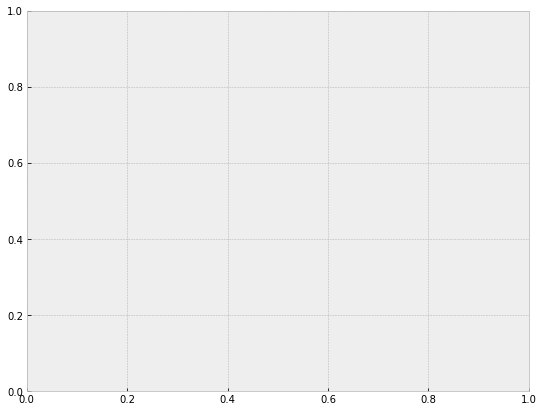

In [48]:
# нарисуем 21 дневный прогноз  доходности SPY

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()
ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


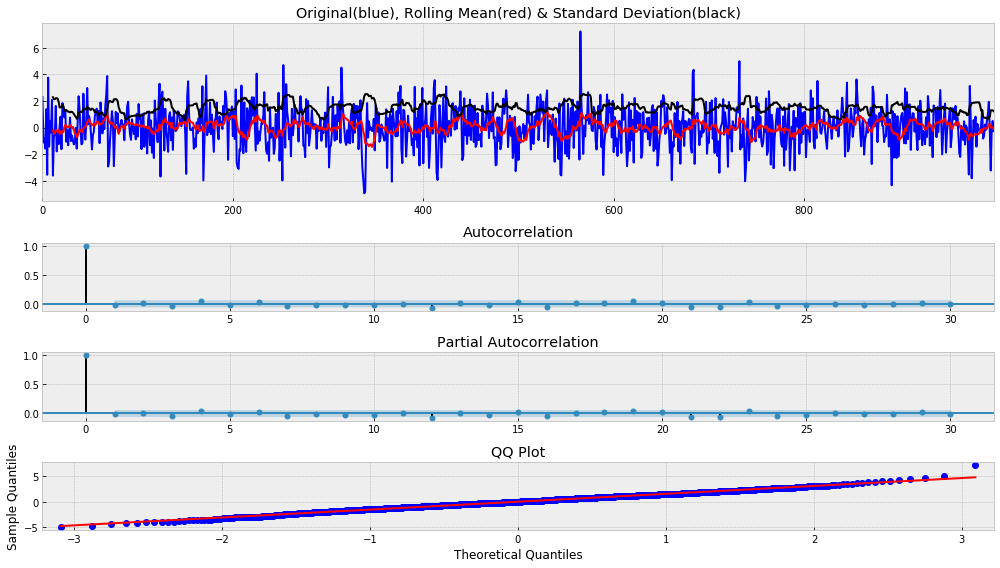

In [49]:
# Симулируем ARCH(1) процесс
# Var(yt) = a_0 + a_1*y{t-1}**2

np.random.seed(1)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

#  ARCH(1) должен напоминать белый шум
tsplot(Y, lags=30)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


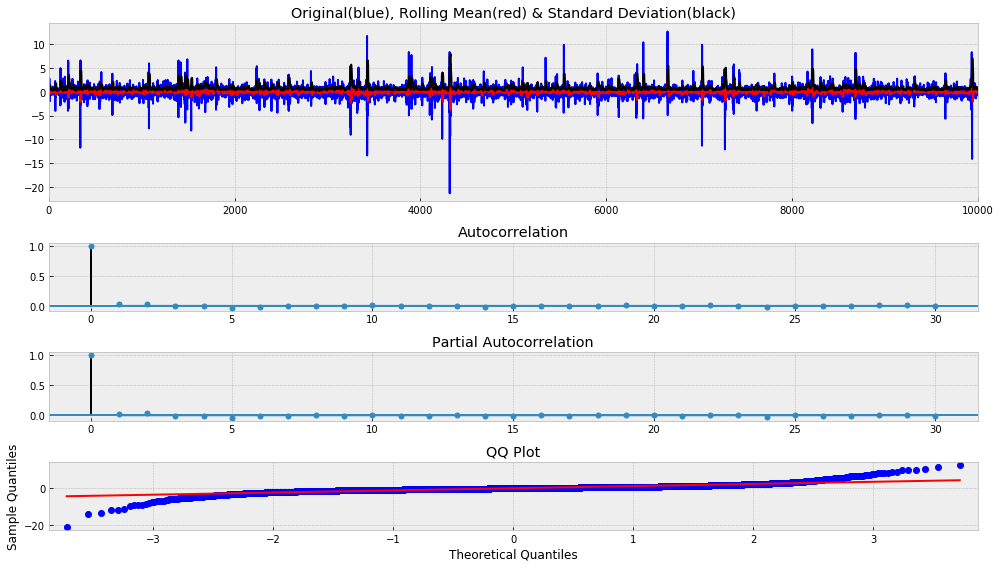

In [50]:
# Симулируем GARCH(1, 1)  процесс
np.random.seed(1)

a0 = 0.2
a1 = 0.8
b1 = 0.1

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

In [51]:
# Оценим GARCH(1, 1)

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 11930.436979269618
Iteration:     10,   Func. Count:     72,   Neg. LLF: 11743.00942400322
Iteration:     15,   Func. Count:    102,   Neg. LLF: 11738.693240800658
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11738.693240800818
            Iterations: 15
            Function evaluations: 102
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -11738.7
Distribution:                  Normal   AIC:                           23485.4
Method:            Maximum Likelihood   BIC:                           23514.2
                                        No. Observations:                10000
Date:            

In [52]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [53]:
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

NameError: name 'lrets' is not defined

In [54]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

NameError: name 'best_order' is not defined

In [55]:
# Прогнозирование
forecasts = res.forecast(horizon=5)
p(forecasts.mean.iloc[-3:])
p(forecasts.residual_variance.iloc[-3:])
p(forecasts.variance.iloc[-3:])

           h.1       h.2       h.3       h.4       h.5
9997       NaN       NaN       NaN       NaN       NaN
9998       NaN       NaN       NaN       NaN       NaN
9999 -0.001607 -0.001607 -0.001607 -0.001607 -0.001607
           h.1       h.2       h.3       h.4       h.5
9997       NaN       NaN       NaN       NaN       NaN
9998       NaN       NaN       NaN       NaN       NaN
9999  0.626225  0.755025  0.867612  0.966028  1.052056
           h.1       h.2       h.3       h.4       h.5
9997       NaN       NaN       NaN       NaN       NaN
9998       NaN       NaN       NaN       NaN       NaN
9999  0.626225  0.755025  0.867612  0.966028  1.052056
